In [1]:
%matplotlib notebook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%matplotlib inline

In [3]:
from glob import glob

In [4]:
!pip install celluloid
from celluloid import Camera

1:load data

Install the celluloid library at runtime for animation
Camera is used to record images frame by frame and make dynamic graphs.

In [5]:
path = Path("/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/0")  # Select a subject. Check the folder if it exists

In [6]:
list(path.glob("*"))

[PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/0/reconstructed_data'),
 PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/0/masks')]

In [7]:
# Choose a file and load slice + mask
file = "3.npy"
slice = np.load(path/"reconstructed_data"/file)
mask = np.load(path/"masks"/file)

In [8]:
from IPython.display import HTML

2:Visual slice and mask

mask the portion of the mask whose median value is 0.

A normal value of 0 in the mask represents the background, and a non-zero value represents the target area

In [9]:
%matplotlib inline


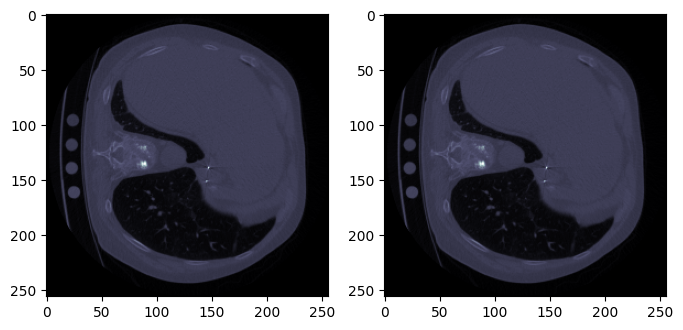

In [10]:
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")

In [11]:
print(slice.min(), slice.max())

-0.33344187561055033 0.9192445457505698


In [12]:
!pip install pytorch_lightning

In [13]:
!pip uninstall imgaug --yes
!pip install imgaug

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 19.4 MB/s eta 0:00:0000:01


3:Define the data set class

In [14]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [15]:
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

class LungDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    # @staticmethod
    # def extract_files(root):
    #     """
    #     Extract the paths to all slices given the root path (ends with train or val)
    #     """
    #     files = []
    #     for subject in root.glob("*"):   # Iterate over the subjects
    #         slice_path = subject/"data"  # Get the slices for current subject
    #         for slice in slice_path.glob("*"):
    #             files.append(slice)
    #     return files     这次错了
    
    @staticmethod
    def extract_files(root):
        """
        提取所有切片文件路径
        """
        files = []
        for subject in root.glob("*"):  # 遍历每个子目录
            slice_path = subject / "reconstructed_data"  # 每个子目录下的 data 文件夹
            if slice_path.exists():  # 检查 data 文件夹是否存在
                for slice_file in slice_path.glob("*.npy"):  # 查找所有 .npy 文件
                    files.append(slice_file)
        return files

    
    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[parts.index("reconstructed_data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        ###################IMPORTANT###################
        # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
        random_seed = torch.randint(0, 1000000, (1,))[0].item()
        imgaug.seed(random_seed)
        #####################################################

        mask = mask.astype(np.uint8)  # 将掩膜转换为无符号整数 ！！
        mask = SegmentationMapsOnImage(mask, mask.shape)
        
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)
    
    
    def __getitem__(self, idx):
        """
        Given an index return the (augmented) slice and corresponding mask
        Add another dimension for pytorch
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path)
        mask = np.load(mask_path)
        
        # 转换掩膜数据类型为 uint8
        mask = mask.astype(np.uint8)
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)
                

In [16]:
class DoubleConv(torch.nn.Module):
    """
    Helper Class which implements the intermediate Convolutions
    """
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())
        
    def forward(self, X):
        return self.step(X)


class UNet(torch.nn.Module):
    """
    This class implements a UNet for the Segmentation
    We use 3 down- and 3 UpConvolutions and two Convolutions in each step
    """

    def __init__(self):
        """Sets up the U-Net Structure
        """
        super().__init__()
        
        
        ############# DOWN #####################
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)

        #########################################

        ############## UP #######################
        self.layer5 = DoubleConv(512 + 256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)
        #########################################

        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self, x):
        
        ####### DownConv 1#########
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        ###########################
        
        ####### DownConv 2#########        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        ###########################

        ####### DownConv 3#########        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        ###########################
        
        ##### Intermediate Layer ## 
        x4 = self.layer4(x3m)
        ###########################

        ####### UpCONV 1#########        
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)  # Upsample with a factor of 2
        #x5 = torch.nn.ConvTranspose2d(512, 512, 2, 2)(x4)
        x5 = torch.cat([x5, x3], dim=1)  # Skip-Connection
        x5 = self.layer5(x5)
        ###########################

        ####### UpCONV 2#########        
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)        
        #x6 = torch.nn.ConvTranspose2d(256, 256, 2, 2)(x5)
        x6 = torch.cat([x6, x2], dim=1)  # Skip-Connection    
        x6 = self.layer6(x6)
        ###########################
        
        ####### UpCONV 3#########        
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        #x7 = torch.nn.ConvTranspose2d(128, 128, 2, 2)(x6)
        x7 = torch.cat([x7, x1], dim=1)       
        x7 = self.layer7(x7)
        ###########################
        
        ####### Predicted segmentation#########        
        ret = self.layer8(x7)
        return ret

4:data enhancement

In [17]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15),   # Translation
               scale=(0.85, 1.15),         # zoom 
               rotate=(-45, 45)            # rotation
               ),  
    iaa.ElasticTransformation()            # Elastic Transformations
                ])


In [18]:
train_path = Path("/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/")
val_path = Path("/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/val")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 14179 train images and 1588 val images


In [19]:
print(list(train_path.glob("*")))  # 列出 train 目录下的内容
print(list(val_path.glob("*")))    # 列出 val 目录下的内容


[PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/7'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/47'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/17'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/19'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/22'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/2'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/35'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/50'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/23'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/work

In [20]:
# 检查 train_path 目录
print(f"Train path content: {list(train_path.glob('*'))}")

# 检查 val_path 目录
print(f"Validation path content: {list(val_path.glob('*'))}")


Train path content: [PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/7'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/47'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/17'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/19'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/22'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/2'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/35'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/50'), PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/23'), PosixPath('/kaggle/input/lung-cancer-segmentation-prep

5:Balanced data set

1 indicates the tumor category (there are non-zero pixels in the mask).
0 indicates the non-tumor category (all zero pixels in the mask).

In [21]:
# create a list containing only the class labels
target_list = []
for _, label in tqdm(train_dataset):
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)
     

  0%|          | 0/14179 [00:00<?, ?it/s]

Statistical class distribution

In [22]:
uniques = np.unique(target_list, return_counts=True)
uniques

(array([0, 1]), array([12685,  1494]))

The number of samples without tumor (0) was 12688.
The number of samples with tumors (1) was 1491

In [23]:
fraction = uniques[1][0] / uniques[1][1]
fraction

8.490629183400268

The number of samples without tumors was about 8.5 times that of samples with tumors

Create a weight list

In [24]:
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [25]:
import numpy as np

# 将 target_list 转换为 NumPy 数组
target_array = np.array(target_list)

# 将 weight_list 也转换为 NumPy 数组
weight_array = np.array(weight_list)

# 打印类别 0 和类别 1 的权重
print(f"Weight for class 0: {weight_array[target_array == 0][0]}")  # 应为 1
print(f"Weight for class 1: {weight_array[target_array == 1][0]}")  # 应为 fraction


Weight for class 0: 1.0
Weight for class 1: 8.490629183400268


In [26]:
print(f"Target array: {target_array}")
print(f"Weight array: {weight_array}")


Target array: [0 1 0 ... 0 0 0]
Weight array: [1.         8.49062918 1.         ... 1.         1.         1.        ]


In [27]:
# Check category distribution
uniques, counts = np.unique(target_array, return_counts=True)
print(f"Unique classes: {uniques}")
print(f"Counts: {counts}")


Unique classes: [0 1]
Counts: [12685  1494]


Create a weight sampler

In [28]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))  

Define the data loader

In [102]:
batch_size = 16#chng
num_workers = 4#chng


# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
#                                            num_workers=num_workers, sampler=sampler)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# 为训练和验证集创建数据加载器
train_loader = torch.utils.data.DataLoader(
    train_dataset,  # 使用增强后的数据集
    batch_size=16,
    shuffle=True,
    num_workers=4
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,  # 验证集不需要数据增强
    batch_size=16,
    shuffle=False,
    num_workers=4
)


Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...


In [30]:
verify_sampler = next(iter(train_loader))  # Take one batch

In [31]:
(verify_sampler[1][:,0]).sum([1, 2]) > 0  # ~ half the batch size 

tensor([False, False, False, False, False,  True, False,  True,  True, False,
        False,  True,  True, False,  True, False])

Check that the category distribution is close to equilibrium:

In [32]:
result = (verify_sampler[1][:, 0]).sum([1, 2]) > 0
print(f"Batch contains {result.sum()} images with tumors and {len(result) - result.sum()} without tumors.")


Batch contains 6 images with tumors and 10 without tumors.


6: Segmentation model training

In [33]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")


GPU is available
Using GPU: Tesla P100-PCIE-16GB


In [34]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")


CUDA available: True
Current device: 0
Device name: Tesla P100-PCIE-16GB


import torchmetrics
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

        # 添加准确率和 F1 分数的度量
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.train_f1 = torchmetrics.F1Score(task="binary")
        self.val_f1 = torchmetrics.F1Score(task="binary")
    
    def forward(self, data):
        data = data.float()
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        
        pred = self(ct)
        loss = self.loss_fn(pred, mask)

         # 计算准确率和 F1 分数
        pred_binary = (pred > 0.5).float()
        self.train_acc.update(pred_binary, mask.int())
        self.train_f1.update(pred_binary, mask.int())

        # 打印训练信息
        print(f"Epoch {self.current_epoch}, Batch {batch_idx}, Train Loss: {loss.item():.4f}, Train Accuracy: {acc:.4f}, Train F1 Score: {f1:.4f}")

        # 记录日志
        self.log("Train Loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("Train Accuracy", self.train_acc.compute(), on_step=False, on_epoch=True, prog_bar=True)
        self.log("Train F1 Score", self.train_f1.compute(), on_step=False, on_epoch=True, prog_bar=True)

        return loss
        
        # # Logs
        # self.log("Train Dice", loss)
        # if batch_idx % 50 == 0:
        #     self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train") # Record images every 50 steps
        # return loss
    
        
    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()

        pred = self(ct)
        loss = self.loss_fn(pred, mask)

        # 计算准确率和 F1 分数
        pred_binary = (pred > 0.5).float()
        acc = self.val_acc(pred_binary, mask.int())
        f1 = self.val_f1(pred_binary, mask.int())

        # 打印验证信息
        if batch_idx == 0:  # 每个 epoch 打印一次即可
            print(f"Epoch {self.current_epoch}, Val Loss: {loss.item():.4f}, Val Accuracy: {acc:.4f}, Val F1 Score: {f1:.4f}")


        # 记录日志
        self.log("Val Loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("Val Accuracy", self.val_acc.compute(), on_step=False, on_epoch=True, prog_bar=True)
        self.log("Val F1 Score", self.val_f1.compute(), on_step=False, on_epoch=True, prog_bar=True)

        return loss
        
        # # Logs
        # self.log("Val Dice", loss)
        # if batch_idx % 50 == 0:
        #     self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        # return loss

    
    def log_images(self, ct, pred, mask, name):
        
        results = []
        
        pred = pred > 0.5 # As we use the sigomid activation function, we threshold at 0.5
        
        
        fig, axis = plt.subplots(1, 2)
        
        # Draw the Ground Truth image
        
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")

        # Draw a prediction image
        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        # Record to TensorBoard
        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)

            
    
    def configure_optimizers(self):
        #We always need to return a list here (just pack our optimizer into one :))
        return [self.optimizer]


import torchmetrics
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

        # 添加准确率和 F1 分数的度量
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.train_f1 = torchmetrics.F1Score(task="binary")
        self.val_f1 = torchmetrics.F1Score(task="binary")
    
    def forward(self, data):
        data = data.float()
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        
        pred = self(ct)
        loss = self.loss_fn(pred, mask)

        # 计算准确率和 F1 分数
        pred_binary = (pred > 0.5).float()
        self.train_acc.update(pred_binary, mask.int())
        self.train_f1.update(pred_binary, mask.int())

        # 打印训练信息
        print(f"Epoch {self.current_epoch}, Batch {batch_idx}, Train Loss: {loss.item():.4f}, Train Accuracy: {self.train_acc.compute():.4f}")

        # 记录日志
        self.log("Train Loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("Train Accuracy", self.train_acc.compute(), on_step=False, on_epoch=True, prog_bar=True)
        self.log("Train F1 Score", self.train_f1.compute(), on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()

        pred = self(ct)
        loss = self.loss_fn(pred, mask)

        # 计算准确率和 F1 分数
        pred_binary = (pred > 0.5).float()
        acc = self.val_acc(pred_binary, mask.int())
        # self.val_acc.update(pred_binary, mask.int())
        # self.val_f1.update(pred_binary, mask.int())

        # 打印验证信息
        if batch_idx == 0:  # 每个 epoch 打印一次即可
            print(f"Epoch {self.current_epoch}, Val Loss: {loss.item():.4f}, Val Accuracy: {self.val_acc.compute():.4f}, Val F1 Score: {self.val_f1.compute():.4f}")

        # 记录日志
        self.log("Val Loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("Val Accuracy", self.val_acc.compute(), on_step=False, on_epoch=True, prog_bar=True)
        self.log("Val F1 Score", self.val_f1.compute(), on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_epoch_start(self):
        self.train_acc.reset()
        self.val_acc.reset()
        self.train_f1.reset()
        self.val_f1.reset()

    def configure_optimizers(self):
        return [self.optimizer]


In [91]:
import torchmetrics
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        # self.loss_fn = torch.nn.BCEWithLogitsLoss()
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([20.0]))

        # 添加准确率和 F1 分数的度量
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.train_f1 = torchmetrics.F1Score(task="binary")
        self.val_f1 = torchmetrics.F1Score(task="binary")
    
    def forward(self, data):
        data = data.float()
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        
        pred = self(ct)
        loss = self.loss_fn(pred, mask)

        # 计算准确率和更新 F1 分数
        pred_binary = (pred > 0.5).float()
        self.train_acc.update(pred_binary, mask.int())
        self.train_f1.update(pred_binary, mask.int())

        # 打印训练信息
        print(f"Epoch {self.current_epoch}, Batch {batch_idx}, Train Loss: {loss.item():.4f}, Train Accuracy: {self.train_acc.compute():.4f}")

        # 记录日志
        self.log("Train Loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("Train Accuracy", self.train_acc.compute(), on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()

        pred = self(ct)
        loss = self.loss_fn(pred, mask)

        # 更新验证指标
        pred_binary = (pred > 0.5).float()
        self.val_acc.update(pred_binary, mask.int())
        self.val_f1.update(pred_binary, mask.int())

        # 打印验证信息
        if batch_idx == 0:  # 每个 epoch 打印一次即可
            print(f"Epoch {self.current_epoch}, Val Loss: {loss.item():.4f}, Val Accuracy: {self.val_acc.compute():.4f}, Val F1 Score: {self.val_f1.compute():.4f}")

        # 记录日志
        self.log("Val Loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("Val Accuracy", self.val_acc.compute(), on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_epoch_start(self):
        # 重置指标
        self.train_acc.reset()
        self.val_acc.reset()
        self.train_f1.reset()
        self.val_f1.reset()

    def on_epoch_end(self):
        # 打印最终的 F1 分数
        print(f"Epoch {self.current_epoch} Summary:")
        print(f"Train F1 Score: {self.train_f1.compute():.4f}, Val F1 Score: {self.val_f1.compute():.4f}")

    def configure_optimizers(self):
        return [self.optimizer]


In [92]:
import torchmetrics
model = TumorSegmentation() #Create an instance

In [93]:
# # Create the checkpoint callback
# checkpoint_callback = ModelCheckpoint(
#     monitor='Val Dice',
#     save_top_k=30,
#     mode='min')
checkpoint_callback = ModelCheckpoint(
    monitor="Val Loss",  # 修改为已有的验证集指标
    dirpath="./checkpoints",
    filename="best-model-{epoch:02d}-{Val Loss:.4f}",
    save_top_k=1,
    mode="min"  # 对于 Loss，越小越好
)


In [94]:
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("logs", name="tumor_segmentation")

from pytorch_lightning.callbacks import EarlyStopping

# 设置早停回调
early_stopping = EarlyStopping(
    monitor="Val Loss",  # 监控验证集的损失
    patience=5,           # 如果验证集损失在 5 个 epoch 内没有改善，则停止训练
    mode="min"            # 损失越小越好
)
# Create the trainer
gpus = 1 
# trainer = pl.Trainer(accelerator="auto", logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
#                      callbacks=checkpoint_callback,
#                      max_epochs=30,enable_progress_bar=True  # 启用进度条显示
#                     )

trainer = pl.Trainer(
    accelerator="auto",  # 自动选择 GPU 或 CPU
    logger=TensorBoardLogger(save_dir="./logs"),  # 启用 TensorBoardLogger
    log_every_n_steps=100,  # 每步记录日志
    callbacks=[checkpoint_callback, early_stopping],  # 添加检查点回调
    max_epochs=30,  # 设置最大训练轮数
    enable_progress_bar=True,  # 启用进度条显示
)


保存训练历史数据

In [95]:
from pytorch_lightning.callbacks import Callback

class HistoryLogger(Callback):
    def __init__(self):
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": [],
            "train_f1": [],
            "val_f1": [],
        }

    def on_epoch_end(self, trainer, pl_module):
        self.history["train_loss"].append(trainer.callback_metrics["Train Loss"].item())
        self.history["val_loss"].append(trainer.callback_metrics["Val Loss"].item())
        self.history["train_acc"].append(trainer.callback_metrics["Train Accuracy"].item())
        self.history["val_acc"].append(trainer.callback_metrics["Val Accuracy"].item())
        self.history["train_f1"].append(trainer.callback_metrics["Train F1 Score"].item())
        self.history["val_f1"].append(trainer.callback_metrics["Val F1 Score"].item())

# 添加到 Trainer
history_logger = HistoryLogger()
trainer = pl.Trainer(
    logger=logger,
    callbacks=[history_logger],
    accelerator="auto",
    max_epochs=30
)


In [96]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

Start training model

In [97]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"  # 忽略不必要的警告信息

In [98]:
import threading
import time

def keep_kaggle_alive():
    """定期打印信息，防止 Kaggle Notebook 中断"""
    while True:
        print("Keeping Kaggle Notebook alive...")
        time.sleep(60)  # 每 60 秒输出一次信息

# 创建并启动线程
heartbeat = threading.Thread(target=keep_kaggle_alive)
heartbeat.daemon = True  # 设置为守护线程
heartbeat.start()


Keeping Kaggle Notebook alive...


In [99]:
# 检查训练和验证集的类别分布
tumor_pixels = 0
non_tumor_pixels = 0

for _, mask in train_loader:
    tumor_pixels += (mask == 1).sum().item()
    non_tumor_pixels += (mask == 0).sum().item()

print(f"Tumor pixels: {tumor_pixels}, Non-tumor pixels: {non_tumor_pixels}")


Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Tumor pixels: 1985037, Non-tumor pixels: 927249907
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...


In [43]:
trainer.fit(model, train_loader, val_loader)

2025-01-10 07:04:33.157428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 07:04:33.157542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 07:04:33.286101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0, Val Loss: 0.6991, Val Accuracy: 0.9995, Val F1 Score: 0.0000


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, Batch 0, Train Loss: 0.6990, Train Accuracy: 0.9984
Epoch 0, Batch 1, Train Loss: 0.6953, Train Accuracy: 0.9982
Epoch 0, Batch 2, Train Loss: 0.6916, Train Accuracy: 0.9976
Epoch 0, Batch 3, Train Loss: 0.6879, Train Accuracy: 0.9980
Epoch 0, Batch 4, Train Loss: 0.6839, Train Accuracy: 0.9980
Epoch 0, Batch 5, Train Loss: 0.6799, Train Accuracy: 0.9981
Epoch 0, Batch 6, Train Loss: 0.6752, Train Accuracy: 0.9983
Epoch 0, Batch 7, Train Loss: 0.6694, Train Accuracy: 0.9982
Epoch 0, Batch 8, Train Loss: 0.6619, Train Accuracy: 0.9982
Epoch 0, Batch 9, Train Loss: 0.6517, Train Accuracy: 0.9981
Epoch 0, Batch 10, Train Loss: 0.6360, Train Accuracy: 0.9982
Epoch 0, Batch 11, Train Loss: 0.6097, Train Accuracy: 0.9981
Epoch 0, Batch 12, Train Loss: 0.5648, Train Accuracy: 0.9980
Epoch 0, Batch 13, Train Loss: 0.4887, Train Accuracy: 0.9979
Epoch 0, Batch 14, Train Loss: 0.3662, Train Accuracy: 0.9979
Epoch 0, Batch 15, Train Loss: 0.2039, Train Accuracy: 0.9979
Epoch 0, Batch 16,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, Val Loss: 0.0040, Val Accuracy: 0.9990, Val F1 Score: 0.0000
Epoch 1, Batch 0, Train Loss: 0.0129, Train Accuracy: 0.9979
Epoch 1, Batch 1, Train Loss: 0.0096, Train Accuracy: 0.9979
Epoch 1, Batch 2, Train Loss: 0.0071, Train Accuracy: 0.9979
Epoch 1, Batch 3, Train Loss: 0.0143, Train Accuracy: 0.9979
Epoch 1, Batch 4, Train Loss: 0.0066, Train Accuracy: 0.9979
Epoch 1, Batch 5, Train Loss: 0.0066, Train Accuracy: 0.9979
Epoch 1, Batch 6, Train Loss: 0.0099, Train Accuracy: 0.9979
Epoch 1, Batch 7, Train Loss: 0.0091, Train Accuracy: 0.9979
Epoch 1, Batch 8, Train Loss: 0.0224, Train Accuracy: 0.9979
Epoch 1, Batch 9, Train Loss: 0.0238, Train Accuracy: 0.9979
Epoch 1, Batch 10, Train Loss: 0.0130, Train Accuracy: 0.9979
Epoch 1, Batch 11, Train Loss: 0.0126, Train Accuracy: 0.9979
Epoch 1, Batch 12, Train Loss: 0.0086, Train Accuracy: 0.9979
Epoch 1, Batch 13, Train Loss: 0.0158, Train Accuracy: 0.9979
Epoch 1, Batch 14, Train Loss: 0.0212, Train Accuracy: 0.9979
Epoch 1, B

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, Val Loss: 0.0023, Val Accuracy: 0.9997, Val F1 Score: 0.0157
Epoch 2, Batch 0, Train Loss: 0.0029, Train Accuracy: 0.9979
Epoch 2, Batch 1, Train Loss: 0.0053, Train Accuracy: 0.9979
Epoch 2, Batch 2, Train Loss: 0.0070, Train Accuracy: 0.9979
Epoch 2, Batch 3, Train Loss: 0.0053, Train Accuracy: 0.9979
Epoch 2, Batch 4, Train Loss: 0.0038, Train Accuracy: 0.9979
Epoch 2, Batch 5, Train Loss: 0.0111, Train Accuracy: 0.9979
Epoch 2, Batch 6, Train Loss: 0.0052, Train Accuracy: 0.9979
Epoch 2, Batch 7, Train Loss: 0.0051, Train Accuracy: 0.9979
Epoch 2, Batch 8, Train Loss: 0.0099, Train Accuracy: 0.9979
Epoch 2, Batch 9, Train Loss: 0.0043, Train Accuracy: 0.9979
Epoch 2, Batch 10, Train Loss: 0.0108, Train Accuracy: 0.9979
Epoch 2, Batch 11, Train Loss: 0.0023, Train Accuracy: 0.9979
Epoch 2, Batch 12, Train Loss: 0.0131, Train Accuracy: 0.9979
Epoch 2, Batch 13, Train Loss: 0.0068, Train Accuracy: 0.9979
Epoch 2, Batch 14, Train Loss: 0.0023, Train Accuracy: 0.9979
Epoch 2, B

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, Val Loss: 0.0032, Val Accuracy: 0.9996, Val F1 Score: 0.2109
Epoch 3, Batch 0, Train Loss: 0.0031, Train Accuracy: 0.9981
Epoch 3, Batch 1, Train Loss: 0.0024, Train Accuracy: 0.9981
Epoch 3, Batch 2, Train Loss: 0.0029, Train Accuracy: 0.9981
Epoch 3, Batch 3, Train Loss: 0.0026, Train Accuracy: 0.9981
Epoch 3, Batch 4, Train Loss: 0.0022, Train Accuracy: 0.9981
Epoch 3, Batch 5, Train Loss: 0.0050, Train Accuracy: 0.9981
Epoch 3, Batch 6, Train Loss: 0.0077, Train Accuracy: 0.9981
Epoch 3, Batch 7, Train Loss: 0.0036, Train Accuracy: 0.9981
Epoch 3, Batch 8, Train Loss: 0.0054, Train Accuracy: 0.9981
Epoch 3, Batch 9, Train Loss: 0.0061, Train Accuracy: 0.9981
Epoch 3, Batch 10, Train Loss: 0.0025, Train Accuracy: 0.9981
Epoch 3, Batch 11, Train Loss: 0.0047, Train Accuracy: 0.9981
Epoch 3, Batch 12, Train Loss: 0.0049, Train Accuracy: 0.9981
Epoch 3, Batch 13, Train Loss: 0.0063, Train Accuracy: 0.9981
Epoch 3, Batch 14, Train Loss: 0.0038, Train Accuracy: 0.9981
Epoch 3, B

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, Val Loss: 0.0007, Val Accuracy: 0.9996, Val F1 Score: 0.3266
Epoch 4, Batch 0, Train Loss: 0.0039, Train Accuracy: 0.9983
Epoch 4, Batch 1, Train Loss: 0.0045, Train Accuracy: 0.9983
Epoch 4, Batch 2, Train Loss: 0.0026, Train Accuracy: 0.9983
Epoch 4, Batch 3, Train Loss: 0.0023, Train Accuracy: 0.9983
Epoch 4, Batch 4, Train Loss: 0.0020, Train Accuracy: 0.9983
Epoch 4, Batch 5, Train Loss: 0.0026, Train Accuracy: 0.9983
Epoch 4, Batch 6, Train Loss: 0.0040, Train Accuracy: 0.9983
Epoch 4, Batch 7, Train Loss: 0.0018, Train Accuracy: 0.9983
Epoch 4, Batch 8, Train Loss: 0.0036, Train Accuracy: 0.9983
Epoch 4, Batch 9, Train Loss: 0.0017, Train Accuracy: 0.9983
Epoch 4, Batch 10, Train Loss: 0.0048, Train Accuracy: 0.9983
Epoch 4, Batch 11, Train Loss: 0.0046, Train Accuracy: 0.9983
Epoch 4, Batch 12, Train Loss: 0.0011, Train Accuracy: 0.9983
Epoch 4, Batch 13, Train Loss: 0.0018, Train Accuracy: 0.9983
Epoch 4, Batch 14, Train Loss: 0.0040, Train Accuracy: 0.9983
Epoch 4, B

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, Val Loss: 0.0007, Val Accuracy: 0.9997, Val F1 Score: 0.3803
Epoch 5, Batch 0, Train Loss: 0.0020, Train Accuracy: 0.9985
Epoch 5, Batch 1, Train Loss: 0.0031, Train Accuracy: 0.9985
Epoch 5, Batch 2, Train Loss: 0.0023, Train Accuracy: 0.9985
Epoch 5, Batch 3, Train Loss: 0.0020, Train Accuracy: 0.9985
Epoch 5, Batch 4, Train Loss: 0.0018, Train Accuracy: 0.9985
Epoch 5, Batch 5, Train Loss: 0.0018, Train Accuracy: 0.9985
Epoch 5, Batch 6, Train Loss: 0.0019, Train Accuracy: 0.9985
Epoch 5, Batch 7, Train Loss: 0.0016, Train Accuracy: 0.9985
Epoch 5, Batch 8, Train Loss: 0.0021, Train Accuracy: 0.9985
Epoch 5, Batch 9, Train Loss: 0.0027, Train Accuracy: 0.9985
Epoch 5, Batch 10, Train Loss: 0.0014, Train Accuracy: 0.9985
Epoch 5, Batch 11, Train Loss: 0.0017, Train Accuracy: 0.9985
Epoch 5, Batch 12, Train Loss: 0.0016, Train Accuracy: 0.9985
Epoch 5, Batch 13, Train Loss: 0.0016, Train Accuracy: 0.9985
Epoch 5, Batch 14, Train Loss: 0.0016, Train Accuracy: 0.9985
Epoch 5, B

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, Val Loss: 0.0004, Val Accuracy: 0.9997, Val F1 Score: 0.4337
Epoch 6, Batch 0, Train Loss: 0.0020, Train Accuracy: 0.9986
Epoch 6, Batch 1, Train Loss: 0.0027, Train Accuracy: 0.9986
Epoch 6, Batch 2, Train Loss: 0.0008, Train Accuracy: 0.9986
Epoch 6, Batch 3, Train Loss: 0.0022, Train Accuracy: 0.9986
Epoch 6, Batch 4, Train Loss: 0.0023, Train Accuracy: 0.9986
Epoch 6, Batch 5, Train Loss: 0.0021, Train Accuracy: 0.9986
Epoch 6, Batch 6, Train Loss: 0.0019, Train Accuracy: 0.9986
Epoch 6, Batch 7, Train Loss: 0.0009, Train Accuracy: 0.9986
Epoch 6, Batch 8, Train Loss: 0.0027, Train Accuracy: 0.9986
Epoch 6, Batch 9, Train Loss: 0.0012, Train Accuracy: 0.9986
Epoch 6, Batch 10, Train Loss: 0.0030, Train Accuracy: 0.9986
Epoch 6, Batch 11, Train Loss: 0.0019, Train Accuracy: 0.9986
Epoch 6, Batch 12, Train Loss: 0.0011, Train Accuracy: 0.9986
Epoch 6, Batch 13, Train Loss: 0.0017, Train Accuracy: 0.9986
Epoch 6, Batch 14, Train Loss: 0.0019, Train Accuracy: 0.9986
Epoch 6, B

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, Val Loss: 0.0007, Val Accuracy: 0.9997, Val F1 Score: 0.4752
Epoch 7, Batch 0, Train Loss: 0.0021, Train Accuracy: 0.9987
Epoch 7, Batch 1, Train Loss: 0.0022, Train Accuracy: 0.9987
Epoch 7, Batch 2, Train Loss: 0.0016, Train Accuracy: 0.9987
Epoch 7, Batch 3, Train Loss: 0.0007, Train Accuracy: 0.9987
Epoch 7, Batch 4, Train Loss: 0.0016, Train Accuracy: 0.9987
Epoch 7, Batch 5, Train Loss: 0.0013, Train Accuracy: 0.9987
Epoch 7, Batch 6, Train Loss: 0.0013, Train Accuracy: 0.9987
Epoch 7, Batch 7, Train Loss: 0.0019, Train Accuracy: 0.9987
Epoch 7, Batch 8, Train Loss: 0.0018, Train Accuracy: 0.9987
Epoch 7, Batch 9, Train Loss: 0.0023, Train Accuracy: 0.9987
Epoch 7, Batch 10, Train Loss: 0.0018, Train Accuracy: 0.9987
Epoch 7, Batch 11, Train Loss: 0.0011, Train Accuracy: 0.9987
Epoch 7, Batch 12, Train Loss: 0.0021, Train Accuracy: 0.9987
Epoch 7, Batch 13, Train Loss: 0.0031, Train Accuracy: 0.9987
Epoch 7, Batch 14, Train Loss: 0.0008, Train Accuracy: 0.9987
Epoch 7, B

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, Val Loss: 0.0008, Val Accuracy: 0.9997, Val F1 Score: 0.5034
Epoch 8, Batch 0, Train Loss: 0.0026, Train Accuracy: 0.9988
Epoch 8, Batch 1, Train Loss: 0.0017, Train Accuracy: 0.9988
Epoch 8, Batch 2, Train Loss: 0.0020, Train Accuracy: 0.9988
Epoch 8, Batch 3, Train Loss: 0.0016, Train Accuracy: 0.9988
Epoch 8, Batch 4, Train Loss: 0.0008, Train Accuracy: 0.9988
Epoch 8, Batch 5, Train Loss: 0.0007, Train Accuracy: 0.9988
Epoch 8, Batch 6, Train Loss: 0.0017, Train Accuracy: 0.9988
Epoch 8, Batch 7, Train Loss: 0.0012, Train Accuracy: 0.9988
Epoch 8, Batch 8, Train Loss: 0.0028, Train Accuracy: 0.9988
Epoch 8, Batch 9, Train Loss: 0.0023, Train Accuracy: 0.9988
Epoch 8, Batch 10, Train Loss: 0.0013, Train Accuracy: 0.9988
Epoch 8, Batch 11, Train Loss: 0.0030, Train Accuracy: 0.9988
Epoch 8, Batch 12, Train Loss: 0.0010, Train Accuracy: 0.9988
Epoch 8, Batch 13, Train Loss: 0.0016, Train Accuracy: 0.9988
Epoch 8, Batch 14, Train Loss: 0.0017, Train Accuracy: 0.9988
Epoch 8, B

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, Val Loss: 0.0009, Val Accuracy: 0.9997, Val F1 Score: 0.5284
Epoch 9, Batch 0, Train Loss: 0.0011, Train Accuracy: 0.9989
Epoch 9, Batch 1, Train Loss: 0.0015, Train Accuracy: 0.9989
Epoch 9, Batch 2, Train Loss: 0.0013, Train Accuracy: 0.9989
Epoch 9, Batch 3, Train Loss: 0.0018, Train Accuracy: 0.9989
Epoch 9, Batch 4, Train Loss: 0.0026, Train Accuracy: 0.9989
Epoch 9, Batch 5, Train Loss: 0.0007, Train Accuracy: 0.9989
Epoch 9, Batch 6, Train Loss: 0.0011, Train Accuracy: 0.9989
Epoch 9, Batch 7, Train Loss: 0.0041, Train Accuracy: 0.9989
Epoch 9, Batch 8, Train Loss: 0.0015, Train Accuracy: 0.9989
Epoch 9, Batch 9, Train Loss: 0.0030, Train Accuracy: 0.9989
Epoch 9, Batch 10, Train Loss: 0.0021, Train Accuracy: 0.9989
Epoch 9, Batch 11, Train Loss: 0.0021, Train Accuracy: 0.9989
Epoch 9, Batch 12, Train Loss: 0.0017, Train Accuracy: 0.9989
Epoch 9, Batch 13, Train Loss: 0.0026, Train Accuracy: 0.9989
Epoch 9, Batch 14, Train Loss: 0.0018, Train Accuracy: 0.9989
Epoch 9, B

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, Val Loss: 0.0005, Val Accuracy: 0.9998, Val F1 Score: 0.5422
Epoch 10, Batch 0, Train Loss: 0.0015, Train Accuracy: 0.9989
Epoch 10, Batch 1, Train Loss: 0.0019, Train Accuracy: 0.9989
Epoch 10, Batch 2, Train Loss: 0.0031, Train Accuracy: 0.9989
Epoch 10, Batch 3, Train Loss: 0.0024, Train Accuracy: 0.9989
Epoch 10, Batch 4, Train Loss: 0.0015, Train Accuracy: 0.9989
Epoch 10, Batch 5, Train Loss: 0.0021, Train Accuracy: 0.9989
Epoch 10, Batch 6, Train Loss: 0.0019, Train Accuracy: 0.9989
Epoch 10, Batch 7, Train Loss: 0.0017, Train Accuracy: 0.9989
Epoch 10, Batch 8, Train Loss: 0.0016, Train Accuracy: 0.9989
Epoch 10, Batch 9, Train Loss: 0.0015, Train Accuracy: 0.9989
Epoch 10, Batch 10, Train Loss: 0.0017, Train Accuracy: 0.9989
Epoch 10, Batch 11, Train Loss: 0.0007, Train Accuracy: 0.9989
Epoch 10, Batch 12, Train Loss: 0.0005, Train Accuracy: 0.9989
Epoch 10, Batch 13, Train Loss: 0.0010, Train Accuracy: 0.9989
Epoch 10, Batch 14, Train Loss: 0.0028, Train Accuracy: 0.

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, Val Loss: 0.0008, Val Accuracy: 0.9998, Val F1 Score: 0.5523
Epoch 11, Batch 0, Train Loss: 0.0015, Train Accuracy: 0.9990
Epoch 11, Batch 1, Train Loss: 0.0012, Train Accuracy: 0.9990
Epoch 11, Batch 2, Train Loss: 0.0010, Train Accuracy: 0.9990
Epoch 11, Batch 3, Train Loss: 0.0021, Train Accuracy: 0.9990
Epoch 11, Batch 4, Train Loss: 0.0011, Train Accuracy: 0.9990
Epoch 11, Batch 5, Train Loss: 0.0013, Train Accuracy: 0.9990
Epoch 11, Batch 6, Train Loss: 0.0014, Train Accuracy: 0.9990
Epoch 11, Batch 7, Train Loss: 0.0012, Train Accuracy: 0.9990
Epoch 11, Batch 8, Train Loss: 0.0019, Train Accuracy: 0.9990
Epoch 11, Batch 9, Train Loss: 0.0012, Train Accuracy: 0.9990
Epoch 11, Batch 10, Train Loss: 0.0014, Train Accuracy: 0.9990
Epoch 11, Batch 11, Train Loss: 0.0016, Train Accuracy: 0.9990
Epoch 11, Batch 12, Train Loss: 0.0013, Train Accuracy: 0.9990
Keeping Kaggle Notebook alive...
Epoch 11, Batch 13, Train Loss: 0.0006, Train Accuracy: 0.9990
Epoch 11, Batch 14, Trai

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, Val Loss: 0.0003, Val Accuracy: 0.9998, Val F1 Score: 0.5637
Epoch 12, Batch 0, Train Loss: 0.0010, Train Accuracy: 0.9990
Epoch 12, Batch 1, Train Loss: 0.0010, Train Accuracy: 0.9990
Epoch 12, Batch 2, Train Loss: 0.0007, Train Accuracy: 0.9990
Epoch 12, Batch 3, Train Loss: 0.0008, Train Accuracy: 0.9990
Epoch 12, Batch 4, Train Loss: 0.0011, Train Accuracy: 0.9990
Epoch 12, Batch 5, Train Loss: 0.0008, Train Accuracy: 0.9990
Epoch 12, Batch 6, Train Loss: 0.0006, Train Accuracy: 0.9990
Epoch 12, Batch 7, Train Loss: 0.0009, Train Accuracy: 0.9990
Epoch 12, Batch 8, Train Loss: 0.0019, Train Accuracy: 0.9990
Epoch 12, Batch 9, Train Loss: 0.0012, Train Accuracy: 0.9990
Epoch 12, Batch 10, Train Loss: 0.0016, Train Accuracy: 0.9990
Epoch 12, Batch 11, Train Loss: 0.0013, Train Accuracy: 0.9990
Epoch 12, Batch 12, Train Loss: 0.0014, Train Accuracy: 0.9990
Epoch 12, Batch 13, Train Loss: 0.0004, Train Accuracy: 0.9990
Epoch 12, Batch 14, Train Loss: 0.0006, Train Accuracy: 0

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, Val Loss: 0.0005, Val Accuracy: 0.9998, Val F1 Score: 0.5747
Epoch 13, Batch 0, Train Loss: 0.0013, Train Accuracy: 0.9990
Epoch 13, Batch 1, Train Loss: 0.0014, Train Accuracy: 0.9990
Epoch 13, Batch 2, Train Loss: 0.0009, Train Accuracy: 0.9990
Epoch 13, Batch 3, Train Loss: 0.0011, Train Accuracy: 0.9990
Epoch 13, Batch 4, Train Loss: 0.0019, Train Accuracy: 0.9990
Epoch 13, Batch 5, Train Loss: 0.0008, Train Accuracy: 0.9990
Epoch 13, Batch 6, Train Loss: 0.0013, Train Accuracy: 0.9990
Keeping Kaggle Notebook alive...
Epoch 13, Batch 7, Train Loss: 0.0021, Train Accuracy: 0.9990
Epoch 13, Batch 8, Train Loss: 0.0011, Train Accuracy: 0.9990
Epoch 13, Batch 9, Train Loss: 0.0006, Train Accuracy: 0.9990
Epoch 13, Batch 10, Train Loss: 0.0028, Train Accuracy: 0.9990
Epoch 13, Batch 11, Train Loss: 0.0017, Train Accuracy: 0.9990
Epoch 13, Batch 12, Train Loss: 0.0012, Train Accuracy: 0.9990
Epoch 13, Batch 13, Train Loss: 0.0006, Train Accuracy: 0.9990
Epoch 13, Batch 14, Trai

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, Val Loss: 0.0006, Val Accuracy: 0.9998, Val F1 Score: 0.5839
Epoch 14, Batch 0, Train Loss: 0.0013, Train Accuracy: 0.9991
Epoch 14, Batch 1, Train Loss: 0.0016, Train Accuracy: 0.9991
Epoch 14, Batch 2, Train Loss: 0.0010, Train Accuracy: 0.9991
Epoch 14, Batch 3, Train Loss: 0.0005, Train Accuracy: 0.9991
Epoch 14, Batch 4, Train Loss: 0.0005, Train Accuracy: 0.9991
Epoch 14, Batch 5, Train Loss: 0.0012, Train Accuracy: 0.9991
Epoch 14, Batch 6, Train Loss: 0.0005, Train Accuracy: 0.9991
Epoch 14, Batch 7, Train Loss: 0.0008, Train Accuracy: 0.9991
Epoch 14, Batch 8, Train Loss: 0.0007, Train Accuracy: 0.9991
Epoch 14, Batch 9, Train Loss: 0.0004, Train Accuracy: 0.9991
Epoch 14, Batch 10, Train Loss: 0.0008, Train Accuracy: 0.9991
Epoch 14, Batch 11, Train Loss: 0.0014, Train Accuracy: 0.9991
Epoch 14, Batch 12, Train Loss: 0.0007, Train Accuracy: 0.9991
Epoch 14, Batch 13, Train Loss: 0.0004, Train Accuracy: 0.9991
Epoch 14, Batch 14, Train Loss: 0.0011, Train Accuracy: 0

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, Val Loss: 0.0004, Val Accuracy: 0.9998, Val F1 Score: 0.5873
Epoch 15, Batch 0, Train Loss: 0.0008, Train Accuracy: 0.9991
Epoch 15, Batch 1, Train Loss: 0.0011, Train Accuracy: 0.9991
Epoch 15, Batch 2, Train Loss: 0.0005, Train Accuracy: 0.9991
Keeping Kaggle Notebook alive...
Epoch 15, Batch 3, Train Loss: 0.0007, Train Accuracy: 0.9991
Epoch 15, Batch 4, Train Loss: 0.0010, Train Accuracy: 0.9991
Epoch 15, Batch 5, Train Loss: 0.0006, Train Accuracy: 0.9991
Epoch 15, Batch 6, Train Loss: 0.0014, Train Accuracy: 0.9991
Epoch 15, Batch 7, Train Loss: 0.0004, Train Accuracy: 0.9991
Epoch 15, Batch 8, Train Loss: 0.0006, Train Accuracy: 0.9991
Epoch 15, Batch 9, Train Loss: 0.0009, Train Accuracy: 0.9991
Epoch 15, Batch 10, Train Loss: 0.0006, Train Accuracy: 0.9991
Epoch 15, Batch 11, Train Loss: 0.0009, Train Accuracy: 0.9991
Epoch 15, Batch 12, Train Loss: 0.0007, Train Accuracy: 0.9991
Epoch 15, Batch 13, Train Loss: 0.0011, Train Accuracy: 0.9991
Epoch 15, Batch 14, Trai

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, Val Loss: 0.0006, Val Accuracy: 0.9998, Val F1 Score: 0.5948
Epoch 16, Batch 0, Train Loss: 0.0014, Train Accuracy: 0.9991
Epoch 16, Batch 1, Train Loss: 0.0011, Train Accuracy: 0.9991
Epoch 16, Batch 2, Train Loss: 0.0009, Train Accuracy: 0.9991
Epoch 16, Batch 3, Train Loss: 0.0010, Train Accuracy: 0.9991
Epoch 16, Batch 4, Train Loss: 0.0006, Train Accuracy: 0.9991
Epoch 16, Batch 5, Train Loss: 0.0011, Train Accuracy: 0.9991
Epoch 16, Batch 6, Train Loss: 0.0011, Train Accuracy: 0.9991
Epoch 16, Batch 7, Train Loss: 0.0014, Train Accuracy: 0.9991
Epoch 16, Batch 8, Train Loss: 0.0012, Train Accuracy: 0.9991
Epoch 16, Batch 9, Train Loss: 0.0011, Train Accuracy: 0.9991
Epoch 16, Batch 10, Train Loss: 0.0010, Train Accuracy: 0.9991
Epoch 16, Batch 11, Train Loss: 0.0011, Train Accuracy: 0.9991
Epoch 16, Batch 12, Train Loss: 0.0004, Train Accuracy: 0.9991
Epoch 16, Batch 13, Train Loss: 0.0008, Train Accuracy: 0.9991
Epoch 16, Batch 14, Train Loss: 0.0005, Train Accuracy: 0

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, Val Loss: 0.0003, Val Accuracy: 0.9998, Val F1 Score: 0.5993
Keeping Kaggle Notebook alive...
Epoch 17, Batch 0, Train Loss: 0.0008, Train Accuracy: 0.9992
Epoch 17, Batch 1, Train Loss: 0.0012, Train Accuracy: 0.9992
Epoch 17, Batch 2, Train Loss: 0.0016, Train Accuracy: 0.9992
Epoch 17, Batch 3, Train Loss: 0.0008, Train Accuracy: 0.9992
Epoch 17, Batch 4, Train Loss: 0.0007, Train Accuracy: 0.9992
Epoch 17, Batch 5, Train Loss: 0.0006, Train Accuracy: 0.9992
Epoch 17, Batch 6, Train Loss: 0.0013, Train Accuracy: 0.9992
Epoch 17, Batch 7, Train Loss: 0.0002, Train Accuracy: 0.9992
Epoch 17, Batch 8, Train Loss: 0.0010, Train Accuracy: 0.9992
Epoch 17, Batch 9, Train Loss: 0.0006, Train Accuracy: 0.9992
Epoch 17, Batch 10, Train Loss: 0.0015, Train Accuracy: 0.9992
Epoch 17, Batch 11, Train Loss: 0.0010, Train Accuracy: 0.9992
Epoch 17, Batch 12, Train Loss: 0.0011, Train Accuracy: 0.9992
Epoch 17, Batch 13, Train Loss: 0.0006, Train Accuracy: 0.9992
Epoch 17, Batch 14, Trai

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, Val Loss: 0.0003, Val Accuracy: 0.9998, Val F1 Score: 0.6044
Epoch 18, Batch 0, Train Loss: 0.0007, Train Accuracy: 0.9992
Epoch 18, Batch 1, Train Loss: 0.0013, Train Accuracy: 0.9992
Epoch 18, Batch 2, Train Loss: 0.0006, Train Accuracy: 0.9992
Epoch 18, Batch 3, Train Loss: 0.0006, Train Accuracy: 0.9992
Epoch 18, Batch 4, Train Loss: 0.0008, Train Accuracy: 0.9992
Epoch 18, Batch 5, Train Loss: 0.0017, Train Accuracy: 0.9992
Epoch 18, Batch 6, Train Loss: 0.0014, Train Accuracy: 0.9992
Epoch 18, Batch 7, Train Loss: 0.0013, Train Accuracy: 0.9992
Epoch 18, Batch 8, Train Loss: 0.0006, Train Accuracy: 0.9992
Epoch 18, Batch 9, Train Loss: 0.0012, Train Accuracy: 0.9992
Epoch 18, Batch 10, Train Loss: 0.0002, Train Accuracy: 0.9992
Epoch 18, Batch 11, Train Loss: 0.0007, Train Accuracy: 0.9992
Epoch 18, Batch 12, Train Loss: 0.0009, Train Accuracy: 0.9992
Epoch 18, Batch 13, Train Loss: 0.0011, Train Accuracy: 0.9992
Epoch 18, Batch 14, Train Loss: 0.0008, Train Accuracy: 0

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, Val Loss: 0.0007, Val Accuracy: 0.9998, Val F1 Score: 0.6094
Keeping Kaggle Notebook alive...
Epoch 19, Batch 0, Train Loss: 0.0019, Train Accuracy: 0.9992
Epoch 19, Batch 1, Train Loss: 0.0006, Train Accuracy: 0.9992
Epoch 19, Batch 2, Train Loss: 0.0012, Train Accuracy: 0.9992
Epoch 19, Batch 3, Train Loss: 0.0022, Train Accuracy: 0.9992
Epoch 19, Batch 4, Train Loss: 0.0009, Train Accuracy: 0.9992
Epoch 19, Batch 5, Train Loss: 0.0011, Train Accuracy: 0.9992
Epoch 19, Batch 6, Train Loss: 0.0007, Train Accuracy: 0.9992
Epoch 19, Batch 7, Train Loss: 0.0016, Train Accuracy: 0.9992
Epoch 19, Batch 8, Train Loss: 0.0008, Train Accuracy: 0.9992
Epoch 19, Batch 9, Train Loss: 0.0009, Train Accuracy: 0.9992
Epoch 19, Batch 10, Train Loss: 0.0016, Train Accuracy: 0.9992
Epoch 19, Batch 11, Train Loss: 0.0008, Train Accuracy: 0.9992
Epoch 19, Batch 12, Train Loss: 0.0009, Train Accuracy: 0.9992
Epoch 19, Batch 13, Train Loss: 0.0013, Train Accuracy: 0.9992
Epoch 19, Batch 14, Trai

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 22, Batch 463, Train Loss: 0.0012, Train Accuracy: 0.9993
Epoch 22, Batch 464, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 22, Batch 465, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 22, Batch 466, Train Loss: 0.0008, Train Accuracy: 0.9993
Epoch 22, Batch 467, Train Loss: 0.0008, Train Accuracy: 0.9993
Epoch 22, Batch 468, Train Loss: 0.0007, Train Accuracy: 0.9993
Epoch 22, Batch 469, Train Loss: 0.0015, Train Accuracy: 0.9993
Epoch 22, Batch 470, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 22, Batch 471, Train Loss: 0.0013, Train Accuracy: 0.9993
Epoch 22, Batch 472, Train Loss: 0.0013, Train Accuracy: 0.9993
Epoch 22, Batch 473, Train Loss: 0.0012, Train Accuracy: 0.9993
Epoch 22, Batch 474, Train Loss: 0.0006, Train Accuracy: 0.9993
Epoch 22, Batch 475, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 22, Batch 476, Train Loss: 0.0006, Train Accuracy: 0.9993
Epoch 22, Batch 477, Train Loss: 0.0007, Train Accuracy: 0.9993
Epoch 22, Batch 478, Train Loss: 0.0006,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, Val Loss: 0.0005, Val Accuracy: 0.9998, Val F1 Score: 0.6221
Keeping Kaggle Notebook alive...
Epoch 23, Batch 0, Train Loss: 0.0012, Train Accuracy: 0.9993
Epoch 23, Batch 1, Train Loss: 0.0017, Train Accuracy: 0.9993
Epoch 23, Batch 2, Train Loss: 0.0005, Train Accuracy: 0.9993
Epoch 23, Batch 3, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 23, Batch 4, Train Loss: 0.0013, Train Accuracy: 0.9993
Epoch 23, Batch 5, Train Loss: 0.0014, Train Accuracy: 0.9993
Epoch 23, Batch 6, Train Loss: 0.0016, Train Accuracy: 0.9993
Epoch 23, Batch 7, Train Loss: 0.0015, Train Accuracy: 0.9993
Epoch 23, Batch 8, Train Loss: 0.0018, Train Accuracy: 0.9993
Epoch 23, Batch 9, Train Loss: 0.0020, Train Accuracy: 0.9993
Epoch 23, Batch 10, Train Loss: 0.0012, Train Accuracy: 0.9993
Epoch 23, Batch 11, Train Loss: 0.0017, Train Accuracy: 0.9993
Epoch 23, Batch 12, Train Loss: 0.0017, Train Accuracy: 0.9993
Epoch 23, Batch 13, Train Loss: 0.0003, Train Accuracy: 0.9993
Epoch 23, Batch 14, Trai

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 24, Batch 423, Train Loss: 0.0009, Train Accuracy: 0.9993
Epoch 24, Batch 424, Train Loss: 0.0007, Train Accuracy: 0.9993
Epoch 24, Batch 425, Train Loss: 0.0004, Train Accuracy: 0.9993
Epoch 24, Batch 426, Train Loss: 0.0012, Train Accuracy: 0.9993
Epoch 24, Batch 427, Train Loss: 0.0009, Train Accuracy: 0.9993
Epoch 24, Batch 428, Train Loss: 0.0010, Train Accuracy: 0.9993
Epoch 24, Batch 429, Train Loss: 0.0018, Train Accuracy: 0.9993
Epoch 24, Batch 430, Train Loss: 0.0008, Train Accuracy: 0.9993
Epoch 24, Batch 431, Train Loss: 0.0005, Train Accuracy: 0.9993
Epoch 24, Batch 432, Train Loss: 0.0010, Train Accuracy: 0.9993
Epoch 24, Batch 433, Train Loss: 0.0009, Train Accuracy: 0.9993
Epoch 24, Batch 434, Train Loss: 0.0005, Train Accuracy: 0.9993
Epoch 24, Batch 435, Train Loss: 0.0012, Train Accuracy: 0.9993
Epoch 24, Batch 436, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 24, Batch 437, Train Loss: 0.0009, Train Accuracy: 0.9993
Epoch 24, Batch 438, Train Loss: 0.0010,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 26, Batch 252, Train Loss: 0.0005, Train Accuracy: 0.9993
Epoch 26, Batch 253, Train Loss: 0.0012, Train Accuracy: 0.9993
Epoch 26, Batch 254, Train Loss: 0.0004, Train Accuracy: 0.9993
Epoch 26, Batch 255, Train Loss: 0.0010, Train Accuracy: 0.9993
Epoch 26, Batch 256, Train Loss: 0.0009, Train Accuracy: 0.9993
Epoch 26, Batch 257, Train Loss: 0.0008, Train Accuracy: 0.9993
Epoch 26, Batch 258, Train Loss: 0.0002, Train Accuracy: 0.9993
Epoch 26, Batch 259, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 26, Batch 260, Train Loss: 0.0006, Train Accuracy: 0.9993
Epoch 26, Batch 261, Train Loss: 0.0008, Train Accuracy: 0.9993
Epoch 26, Batch 262, Train Loss: 0.0002, Train Accuracy: 0.9993
Epoch 26, Batch 263, Train Loss: 0.0005, Train Accuracy: 0.9993
Epoch 26, Batch 264, Train Loss: 0.0008, Train Accuracy: 0.9993
Epoch 26, Batch 265, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 26, Batch 266, Train Loss: 0.0010, Train Accuracy: 0.9993
Epoch 26, Batch 267, Train Loss: 0.0003,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, Val Loss: 0.0004, Val Accuracy: 0.9998, Val F1 Score: 0.6283
Keeping Kaggle Notebook alive...
Epoch 27, Batch 0, Train Loss: 0.0010, Train Accuracy: 0.9993
Epoch 27, Batch 1, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 27, Batch 2, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 27, Batch 3, Train Loss: 0.0008, Train Accuracy: 0.9993
Epoch 27, Batch 4, Train Loss: 0.0009, Train Accuracy: 0.9993
Epoch 27, Batch 5, Train Loss: 0.0012, Train Accuracy: 0.9993
Epoch 27, Batch 6, Train Loss: 0.0013, Train Accuracy: 0.9993
Epoch 27, Batch 7, Train Loss: 0.0016, Train Accuracy: 0.9993
Epoch 27, Batch 8, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 27, Batch 9, Train Loss: 0.0008, Train Accuracy: 0.9993
Epoch 27, Batch 10, Train Loss: 0.0010, Train Accuracy: 0.9993
Epoch 27, Batch 11, Train Loss: 0.0007, Train Accuracy: 0.9993
Epoch 27, Batch 12, Train Loss: 0.0007, Train Accuracy: 0.9993
Epoch 27, Batch 13, Train Loss: 0.0005, Train Accuracy: 0.9993
Epoch 27, Batch 14, Trai

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, Val Loss: 0.0004, Val Accuracy: 0.9998, Val F1 Score: 0.6292
Epoch 28, Batch 0, Train Loss: 0.0004, Train Accuracy: 0.9993
Epoch 28, Batch 1, Train Loss: 0.0008, Train Accuracy: 0.9993
Epoch 28, Batch 2, Train Loss: 0.0009, Train Accuracy: 0.9993
Epoch 28, Batch 3, Train Loss: 0.0004, Train Accuracy: 0.9993
Epoch 28, Batch 4, Train Loss: 0.0012, Train Accuracy: 0.9993
Epoch 28, Batch 5, Train Loss: 0.0003, Train Accuracy: 0.9993
Epoch 28, Batch 6, Train Loss: 0.0008, Train Accuracy: 0.9993
Epoch 28, Batch 7, Train Loss: 0.0015, Train Accuracy: 0.9993
Epoch 28, Batch 8, Train Loss: 0.0008, Train Accuracy: 0.9993
Epoch 28, Batch 9, Train Loss: 0.0009, Train Accuracy: 0.9993
Epoch 28, Batch 10, Train Loss: 0.0014, Train Accuracy: 0.9993
Epoch 28, Batch 11, Train Loss: 0.0005, Train Accuracy: 0.9993
Epoch 28, Batch 12, Train Loss: 0.0010, Train Accuracy: 0.9993
Epoch 28, Batch 13, Train Loss: 0.0005, Train Accuracy: 0.9993
Epoch 28, Batch 14, Train Loss: 0.0011, Train Accuracy: 0

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, Val Loss: 0.0004, Val Accuracy: 0.9998, Val F1 Score: 0.6311
Keeping Kaggle Notebook alive...
Epoch 29, Batch 0, Train Loss: 0.0005, Train Accuracy: 0.9993
Epoch 29, Batch 1, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 29, Batch 2, Train Loss: 0.0004, Train Accuracy: 0.9993
Epoch 29, Batch 3, Train Loss: 0.0015, Train Accuracy: 0.9993
Epoch 29, Batch 4, Train Loss: 0.0012, Train Accuracy: 0.9993
Epoch 29, Batch 5, Train Loss: 0.0006, Train Accuracy: 0.9993
Epoch 29, Batch 6, Train Loss: 0.0004, Train Accuracy: 0.9993
Epoch 29, Batch 7, Train Loss: 0.0009, Train Accuracy: 0.9993
Epoch 29, Batch 8, Train Loss: 0.0009, Train Accuracy: 0.9993
Epoch 29, Batch 9, Train Loss: 0.0011, Train Accuracy: 0.9993
Epoch 29, Batch 10, Train Loss: 0.0007, Train Accuracy: 0.9993
Epoch 29, Batch 11, Train Loss: 0.0010, Train Accuracy: 0.9993
Epoch 29, Batch 12, Train Loss: 0.0010, Train Accuracy: 0.9993
Epoch 29, Batch 13, Train Loss: 0.0005, Train Accuracy: 0.9993
Epoch 29, Batch 14, Trai

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, Val Loss: 0.0004, Val Accuracy: 0.9998, Val F1 Score: 0.6318


7: save the model 

In [56]:
import os
os.makedirs("./checkpoints", exist_ok=True)


Keeping Kaggle Notebook alive...


In [59]:
trainer.save_checkpoint("final_model_checkpoint.ckpt")
print("Final model checkpoint saved.")


Final model checkpoint saved.
Keeping Kaggle Notebook alive...


In [60]:
print(trainer.callback_metrics)


{'Train Loss': tensor(0.0008), 'Train Loss_step': tensor(9.6478e-05), 'Val Loss': tensor(0.0008), 'Val Accuracy': tensor(0.9998), 'Train Loss_epoch': tensor(0.0008), 'Train Accuracy': tensor(0.9993)}
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...


In [61]:
import os
print("Saved files:", os.listdir("."))


Saved files: ['final_model_weights.pth', '.virtual_documents', 'logs', 'final_model_checkpoint.ckpt', 'checkpoints']


In [62]:
!zip final_model_checkpoint.zip final_model_checkpoint.ckpt


  adding: final_model_checkpoint.ckpt (deflated 9%)
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...


In [63]:
import os
print("Current working directory:", os.getcwd())
print("Saved files:", os.listdir("."))


Current working directory: /kaggle/working
Saved files: ['final_model_weights.pth', '.virtual_documents', 'logs', 'final_model_checkpoint.ckpt', 'checkpoints', 'final_model_checkpoint.zip']
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...


8: evaulation

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 模型评估
model.eval()
all_preds, all_labels = [], []

for ct, mask in val_loader:
    with torch.no_grad():
        pred = model(ct).squeeze() > 0.5  # 阈值化
        all_preds.extend(pred.cpu().numpy().flatten())
        all_labels.extend(mask.cpu().numpy().flatten())

print("Classification Report:")
print(classification_report(all_labels, all_preds))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Classification Report:
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00 104041396
           1       0.83      0.58      0.68     29772

    accuracy         

9: draw loss/accuracy line

In [67]:
model = model.to("cuda")


In [68]:
ct, mask = ct.to("cuda"), mask.to("cuda")


Keeping Kaggle Notebook alive...


In [69]:
print(next(model.parameters()).device)


cuda:0


In [76]:
print("Validation loss:", trainer.logged_metrics.get("Val Loss"))


Validation loss: tensor(0.0008)
Keeping Kaggle Notebook alive...


In [78]:
with torch.no_grad():
    pred = model(ct).squeeze()  # 获取模型原始输出
    print(f"Raw predictions: min={pred.min()}, max={pred.max()}")

    pred_sigmoid = torch.sigmoid(pred)  # 应用 sigmoid 激活函数
    print(f"Sigmoid predictions: min={pred_sigmoid.min()}, max={pred_sigmoid.max()}")


Raw predictions: min=-403.25848388671875, max=-5.999192714691162
Sigmoid predictions: min=0.0, max=0.0024746148847043514
Keeping Kaggle Notebook alive...


In [128]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("logs", name="tumor_segmentation")
trainer = pl.Trainer(logger=logger, max_epochs=30)


Keeping Kaggle Notebook alive...


In [136]:
import os

# 列出当前工作目录
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# 列出日志文件夹中的内容
log_dir = "./logs/tumor_segmentation/version_0"  # 修改为你的实际日志目录
if os.path.exists(log_dir):
    print("Contents of log directory:")
    print(os.listdir(log_dir))
else:
    print(f"Directory {log_dir} does not exist.")



Current directory: /kaggle/working
Contents of log directory:
['hparams.yaml', 'events.out.tfevents.1736492680.0d9eaf08ea45.34.0', 'checkpoints']
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...


In [138]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# 指定日志文件路径
log_file = "/kaggle/working/logs/tumor_segmentation/version_0/events.out.tfevents.1736492680.0d9eaf08ea45.34.0"

# 加载日志文件
event_acc = EventAccumulator(log_file)
event_acc.Reload()

# 获取所有记录的标签
tags = event_acc.Tags()
print(f"Available tags: {tags}")


Available tags: {'images': [], 'audio': [], 'histograms': [], 'scalars': ['Train Loss_step', 'epoch', 'Val Loss', 'Val Accuracy', 'Train Loss_epoch', 'Train Accuracy'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...


In [139]:
# 提取数据
train_loss = [scalar.value for scalar in event_acc.Scalars("Train Loss_epoch")]  # 每轮训练的平均损失
val_loss = [scalar.value for scalar in event_acc.Scalars("Val Loss")]           # 每轮验证的平均损失
train_acc = [scalar.value for scalar in event_acc.Scalars("Train Accuracy")]   # 每轮训练准确率
val_acc = [scalar.value for scalar in event_acc.Scalars("Val Accuracy")]       # 每轮验证准确率

# 检查提取的数据
print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")


Train Loss: [0.025802413001656532, 0.009280990809202194, 0.004403071478009224, 0.00302194245159626, 0.0024660020135343075, 0.0021088249050080776, 0.001753880875185132, 0.0015729134902358055, 0.0014746764209121466, 0.0014639513101428747, 0.0013423592317849398, 0.0012558671878650784, 0.0013135583139955997, 0.001151802483946085, 0.0012391858035698533, 0.0010487590916454792, 0.0010501659708097577, 0.0009882402373477817, 0.0010288823395967484, 0.0009907977655529976, 0.0009579621255397797, 0.0009453135426156223, 0.0010290122590959072, 0.0009119772003032267, 0.0009066298371180892, 0.0009249719441868365, 0.0008624271140433848, 0.0008712171693332493, 0.0009047374478541315, 0.000822154339402914]
Validation Loss: [0.0030998315196484327, 0.0016413492849096656, 0.001897234469652176, 0.0006219700444489717, 0.0007037727627903223, 0.0005567087209783494, 0.00075375015148893, 0.000688590866047889, 0.000794602558016777, 0.0006886463961564004, 0.000575489248149097, 0.0006337943486869335, 0.000655108189675

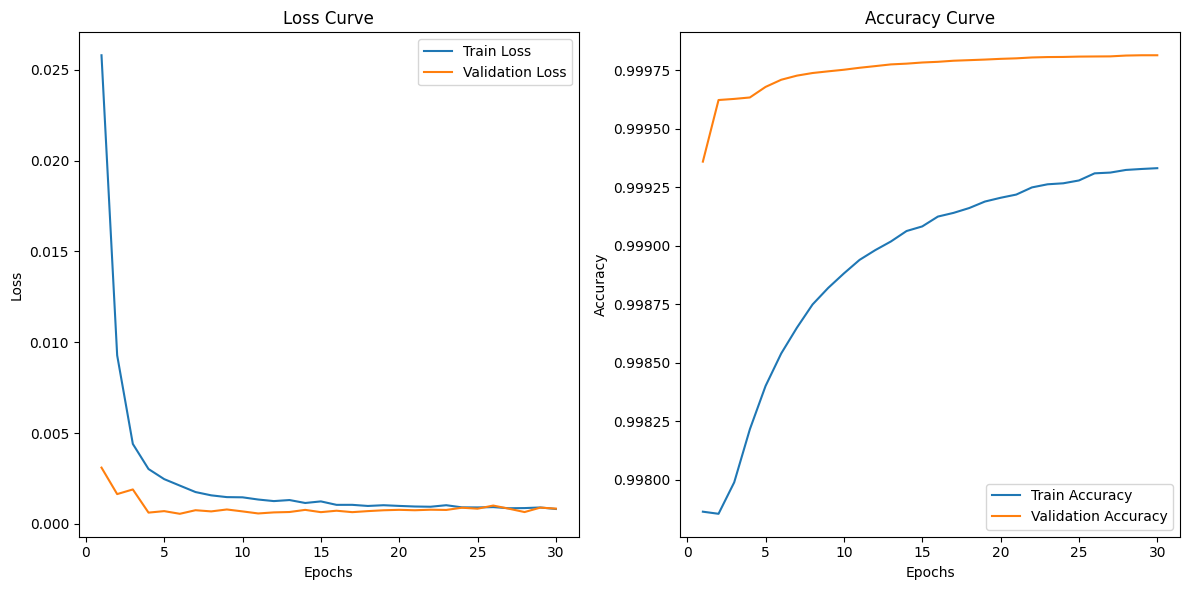

Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...
Keeping Kaggle Notebook alive...


In [140]:
import matplotlib.pyplot as plt

# 定义训练轮次
epochs = range(1, len(train_loss) + 1)

# 绘制 Loss 曲线
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# 绘制 Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [131]:
log_file = "events.out.tfevents.1736492680.0d9eaf08ea45.34.0"


### Result evaluation

In [ ]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()  # Counter       
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum
        
        return dice

In [ ]:
#model = TumorSegmentation.load_from_checkpoint("/content/epoch=29-step=53759.ckpt")
model.eval();
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [ ]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice))
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

In [ ]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

In [ ]:
THRESHOLD = 0.5